<div style="border:solid orange 2px; padding: 20px">

# Сборный проект 2

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.\
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки.\
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Цель проекта:\
Проект выполняется для закрепления пройденного материала, также чтобы потренироваться в выполнении проекта от начала (предобработки данных) до его завершения (создание лучшей модели для бизнеса).

Задачи проекта:
- Подготовка данных:
    - Расчет MAE между расчетами и значениями признака;
    - Анализ признаков, недоступных в тестовой выборке;
    - Предобработка данных;
- Анализ данных:
    - Оценка изменения констрации металлов на разных этапах;
    - Сравнение распределения размеров гранул исходного сырья;
    - Расчет суммарной концентрации металлов на разных стадиях;
- Построение модели:
    - Написание функции smape;
    - Обучение моделей и оценка их качества;
    - Выбор лучшей модели и проверка ее на тестовой выборке.
    
Описание данных:
- Технологический процесс:
    - Rougher feed — исходное сырье
    - Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate — ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
    - Rougher process (англ. «грубый процесс») — флотация
    - Rougher tails — отвальные хвосты
    - Float banks — флотационная установка
    - Cleaner process — очистка
    - Rougher Au — черновой концентрат золота
    - Final Au — финальный концентрат золота
- Параметры этапов:
    - air amount — объём воздуха
    - fluid levels — уровень жидкости
    - feed size — размер гранул сырья
    - feed rate — скорость подачи
- Наименование признаков

    Наименование признаков должно быть такое:
    [этап].[тип_параметра].[название_параметра]
    
    Пример: rougher.input.feed_ag
    
    Возможные значения для блока [этап]:
        - rougher — флотация
        - primary_cleaner — первичная очистка
        - secondary_cleaner — вторичная очистка
        - final — финальные характеристики
    Возможные значения для блока [тип_параметра]:
        - input — параметры сырья
        - output — параметры продукта
        - state — параметры, характеризующие текущее состояние этапа
        - calculation — расчётные характеристики

## Импорт библиотек и выгрузка данных

In [378]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 7)

In [316]:
try:
    g_r_train = pd.read_csv('C:/Users/trombee/YandexDisk/Учеба/Я. Практикум/Сборный проетк - 2/gold_industry_train.csv')
    g_r_test = pd.read_csv('C:/Users/trombee/YandexDisk/Учеба/Я. Практикум/Сборный проетк - 2/gold_industry_test.csv')
    g_r_full = pd.read_csv('C:/Users/trombee/YandexDisk/Учеба/Я. Практикум/Сборный проетк - 2/gold_industry_full.csv')
except:
    g_r_train = pd.read_csv('/datasets/gold_industry_train.csv')
    g_r_test = pd.read_csv('/datasets/gold_industry_test.csv')
    g_r_full = pd.read_csv('/datasets/gold_industry_full.csv')

In [317]:
g_r_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


In [318]:
g_r_train.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,14579.000000,14579.000000,14507.000000,14502.000000,14572.000000,14478.000000,14548.000000,14572.000000,14579.000000,14579.000000,...,13659.000000,14579.000000,14578.000000,14578.000000,14387.000000,14579.000000,14579.000000,14578.000000,14504.000000,14574.000000
mean,8.352941,8.877460,3.604221,36.561420,474.332784,58.922712,12.427399,5.994854,1104.208278,-379.367166,...,7.111347,43.979499,5.192145,9.923809,9.566676,66.759066,3.087939,9.731972,2.719985,10.612745
std,1.934376,1.922536,1.056063,5.209823,108.503552,22.407410,3.428939,1.152873,162.235606,94.652311,...,3.909951,5.471437,1.388014,1.706976,2.805654,10.619709,0.915187,2.358143,0.958929,2.871075
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.049194,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.932996,7.341922,2.880490,34.093951,411.048483,47.278490,10.002832,5.304167,999.644856,-499.861797,...,3.784897,43.345906,4.283347,9.103183,7.860030,63.114596,2.505287,8.088928,2.036512,9.013412
50%,8.225284,8.715859,3.532399,37.097511,498.187968,54.361187,12.003320,6.003053,1000.982624,-300.314199,...,7.629968,44.975014,5.118647,10.046455,9.301970,67.962788,3.029238,9.818512,2.774847,10.670515
75%,9.832210,10.255843,4.257282,39.899799,549.586552,64.464926,14.929903,6.796632,1292.663971,-299.989315,...,10.367050,46.275153,5.925380,10.981203,11.001573,72.598187,3.614098,11.169187,3.353845,12.130827
max,13.731330,14.596026,7.052325,53.475325,717.508837,484.967466,36.118275,9.703448,1512.299531,-273.776101,...,26.000772,52.756638,16.001945,16.705297,19.423912,100.000000,8.245022,19.552149,5.804178,22.317730


In [319]:
g_r_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

In [320]:
g_r_test.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,4860.000000,4860.000000,4832.000000,4838.000000,4856.000000,4816.000000,4857.000000,4859.000000,4859.000000,4859.000000,...,4.859000e+03,4859.000000,4.859000e+03,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000
mean,8.005584,8.547348,3.579662,37.095864,490.285103,59.113400,12.055735,6.101308,1108.635895,-368.340127,...,1.985770e+01,-488.665140,1.557025e+01,-464.176507,16.594103,-490.815250,12.945971,-489.583564,19.053888,-504.678924
std,1.993590,1.958601,1.029377,4.926284,94.371623,19.125122,3.407642,1.042754,156.493143,91.155929,...,5.913105e+00,44.392714,4.927361e+00,65.706994,5.724305,32.258443,5.533176,37.084609,5.548996,38.690186
min,0.010000,0.010000,0.010000,0.010000,0.012786,0.046369,0.018907,0.015783,300.792494,-600.568138,...,1.079872e-16,-799.704969,2.489718e-17,-799.860767,-0.371498,-797.142475,1.358469,-800.006180,0.160386,-809.734800
25%,6.574363,6.975898,2.903612,34.510841,434.099695,47.596984,9.890429,5.499808,999.715729,-499.731972,...,1.501123e+01,-500.704004,1.202172e+01,-500.196517,11.073822,-500.483564,9.011890,-500.129913,14.963953,-500.668501
50%,7.812923,8.179714,3.540772,37.499761,502.118742,55.509481,11.997859,6.099805,1001.414798,-300.181367,...,1.996807e+01,-499.892919,1.501240e+01,-499.540776,16.631195,-499.873136,11.999417,-499.955304,19.960006,-500.033769
75%,9.556589,10.084339,4.199847,40.461315,555.596563,66.661547,14.496072,6.802101,1202.837565,-299.961547,...,2.498900e+01,-498.652030,1.999949e+01,-400.302329,19.983191,-498.852815,15.004198,-499.643776,24.974583,-499.460134
max,13.417156,14.533698,7.142594,53.477742,702.523396,363.989699,30.010759,9.396928,1521.980372,-281.039299,...,3.008450e+01,-383.373053,2.398898e+01,-114.250832,33.215996,-288.963521,24.177106,-141.934397,32.028529,-104.427459


In [321]:
g_r_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


In [322]:
g_r_full.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000000,19439.000000,19339.000000,19340.000000,19428.000000,19294.000000,19405.000000,19431.000000,19438.000000,19438.000000,...,17691.000000,19439.000000,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000
mean,8.266097,8.794927,3.598085,36.695114,478.320042,58.970310,12.334373,6.021474,1105.315068,-376.610690,...,7.167247,44.076513,5.168470,9.978895,9.501224,67.050208,3.042467,9.688589,2.705795,10.583728
std,1.955092,1.936847,1.049486,5.145445,105.373758,21.634478,3.427317,1.127263,160.826798,93.909667,...,3.916079,5.129784,1.372348,1.669240,2.787537,10.125840,0.922808,2.328642,0.949077,2.868782
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.046369,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.854384,7.237967,2.887280,34.207799,416.525453,47.435103,10.000362,5.398678,999.661867,-499.835165,...,3.845475,43.402215,4.251240,9.137262,7.722820,63.299712,2.461138,8.062878,2.040119,8.938947
50%,8.125839,8.593574,3.534895,37.202650,499.416120,54.610197,12.001174,6.008273,1001.072890,-300.263994,...,7.685827,45.011244,5.066094,10.102433,9.218961,68.172738,2.984909,9.743623,2.748730,10.622456
75%,9.769917,10.213771,4.244161,40.039133,550.172183,65.023044,14.716595,6.798051,1205.620588,-299.981998,...,10.411296,46.275313,5.895527,11.035769,10.947813,72.686642,3.571351,11.134294,3.333216,12.104271
max,13.731330,14.596026,7.142594,53.477742,717.508837,484.967466,36.118275,9.703448,1521.980372,-273.776101,...,26.000772,52.756638,16.001945,17.031899,19.615720,100.000000,8.245022,19.552149,5.804178,22.317730


In [323]:
#чтобы ознакомиться со всеми пропусками в данных, использовал метод set_option
pd.set_option('display.max_rows', None)

In [324]:
g_r_train.isna().sum()

date                                                    0
rougher.input.feed_au                                   0
rougher.input.feed_ag                                   0
rougher.input.feed_pb                                  72
rougher.input.feed_sol                                 77
rougher.input.feed_rate                                 7
rougher.input.feed_size                               101
rougher.input.floatbank10_sulfate                      31
rougher.input.floatbank10_xanthate                      7
rougher.state.floatbank10_a_air                         0
rougher.state.floatbank10_a_level                       0
rougher.state.floatbank10_b_air                         0
rougher.state.floatbank10_b_level                       0
rougher.state.floatbank10_c_air                         0
rougher.state.floatbank10_c_level                       0
rougher.state.floatbank10_d_air                         0
rougher.state.floatbank10_d_level                       0
rougher.state.

## Проверка эффективности обогащения

In [325]:
C = g_r_train['rougher.output.concentrate_au']
F = g_r_train['rougher.input.feed_au']
T = g_r_train['rougher.output.tail_au']


recov = ((C * (F - T)) / (F * (C - T))) * 100

In [326]:
mae_recov = mean_absolute_error(g_r_train['rougher.output.recovery'], recov)
print(f'MAE = {mae_recov}')

MAE = 9.83758577644259e-15


In [327]:
g_r_full['date'] = pd.to_datetime(g_r_full['date'])
g_r_train['date'] = pd.to_datetime(g_r_train['date'])
g_r_test['date'] = pd.to_datetime(g_r_test['date'])

In [328]:
#даты преобразовал в индексы
g_r_train = g_r_train.set_index('date')
g_r_test = g_r_test.set_index('date')
g_r_full = g_r_full.set_index('date')

In [329]:
g_r_full.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,-400.074028,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,-400.200179,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,-399.752729,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [330]:
#вывод разницы в столбцах
columns_diff = set(g_r_train) - set(g_r_test)
columns_diff

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [331]:
#добавление целевых признаков в тестовую выборку
g_r_test = g_r_test.merge(g_r_full[['rougher.output.recovery', 'final.output.recovery']], left_index=True, right_index=True)

In [332]:
g_r_test.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,-299.862743,...,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575,89.514960,70.281454
2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,-299.907308,...,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471,89.858126,65.523246
2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,-300.124116,...,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155,91.816623,74.817644
2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,-299.778385,...,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973,88.478959,63.082720
2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,-300.283401,...,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805,89.230316,74.463380


## Предобработка

In [333]:
g_r_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14579 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               14579 non-null  float64
 1   rougher.input.feed_ag                               14579 non-null  float64
 2   rougher.input.feed_pb                               14507 non-null  float64
 3   rougher.input.feed_sol                              14502 non-null  float64
 4   rougher.input.feed_rate                             14572 non-null  float64
 5   rougher.input.feed_size                             14478 non-null  float64
 6   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 7   rougher.input.floatbank10_xanthate                  14572 non-null  float64
 8   rougher.state.floatbank10_a_air          

In [334]:
#заполнение пропусков в данных ближайшим верхним значением
g_r_train.ffill(inplace=True)
g_r_test.ffill(inplace=True)

In [335]:
g_r_train.isna().sum()

rougher.input.feed_au                                 0
rougher.input.feed_ag                                 0
rougher.input.feed_pb                                 0
rougher.input.feed_sol                                0
rougher.input.feed_rate                               0
rougher.input.feed_size                               0
rougher.input.floatbank10_sulfate                     0
rougher.input.floatbank10_xanthate                    0
rougher.state.floatbank10_a_air                       0
rougher.state.floatbank10_a_level                     0
rougher.state.floatbank10_b_air                       0
rougher.state.floatbank10_b_level                     0
rougher.state.floatbank10_c_air                       0
rougher.state.floatbank10_c_level                     0
rougher.state.floatbank10_d_air                       0
rougher.state.floatbank10_d_level                     0
rougher.state.floatbank10_e_air                       0
rougher.state.floatbank10_e_level               

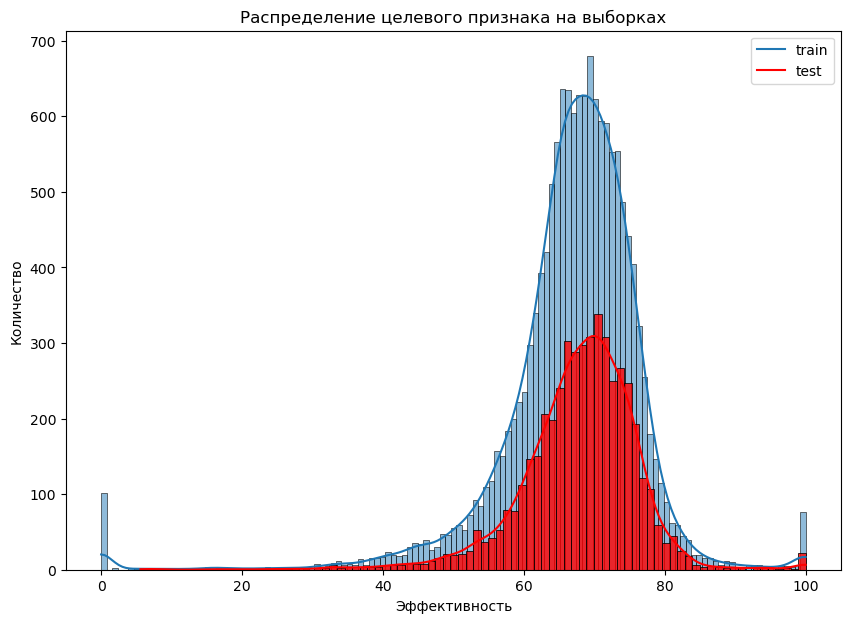

In [336]:
sns.histplot(g_r_train['final.output.recovery'], kde=True, alpha=0.5)
sns.histplot(g_r_test['final.output.recovery'], kde=True, alpha=0.8, color='red')
plt.legend(['train', 'test'])
plt.title('Распределение целевого признака на выборках')
plt.ylabel('Количество')
plt.xlabel('Эффективность')
plt.show()

In [337]:
#количество нулевых значений столбца final.output.recoverу
print(len(g_r_train[g_r_train['final.output.recovery'] == 0]))
len(g_r_test[g_r_test['final.output.recovery'] == 0])

98


0

In [338]:
print(len(g_r_train[g_r_train['final.output.recovery'] == 100]))
len(g_r_test[g_r_test['final.output.recovery'] == 100])

72


19

In [339]:
#количество таких строк не велико, поэтому решил их удалить
g_r_train.drop(index=g_r_train[g_r_train['final.output.recovery'] == 0].index, inplace=True)
g_r_test.drop(index=g_r_test[g_r_test['final.output.recovery'] == 0].index, inplace=True)

g_r_train.drop(index=g_r_train[g_r_train['final.output.recovery'] == 100].index, inplace=True)
g_r_test.drop(index=g_r_test[g_r_test['final.output.recovery'] == 100].index, inplace=True)

In [340]:
print(len(g_r_train[g_r_train['final.output.recovery'] == 0]))
len(g_r_test[g_r_test['final.output.recovery'] == 0])

0


0

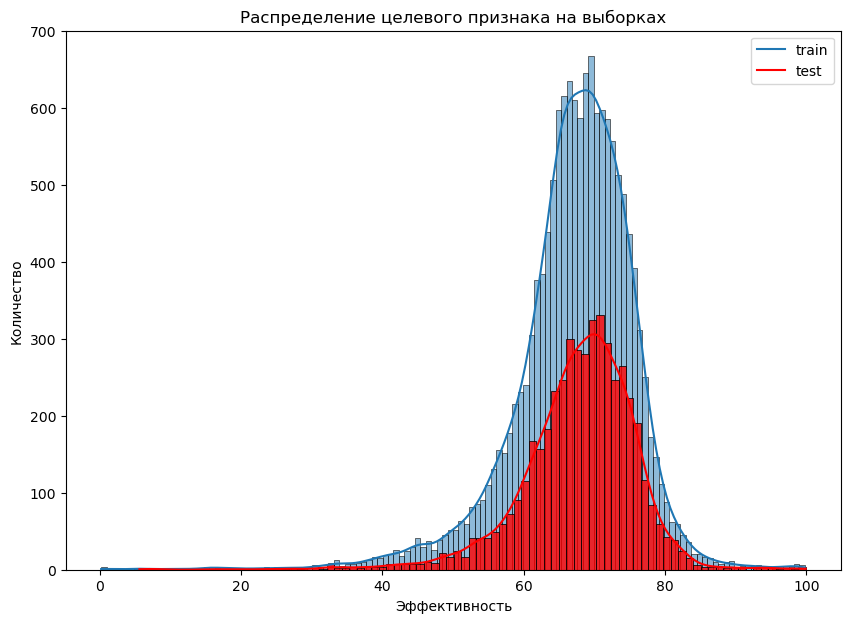

In [341]:
sns.histplot(g_r_train['final.output.recovery'], kde=True, alpha=0.5)
sns.histplot(g_r_test['final.output.recovery'], kde=True, alpha=0.8, color='red')
plt.legend(['train', 'test'])
plt.title('Распределение целевого признака на выборках')
plt.ylabel('Количество')
plt.xlabel('Эффективность')
plt.show()

## Анализ данных

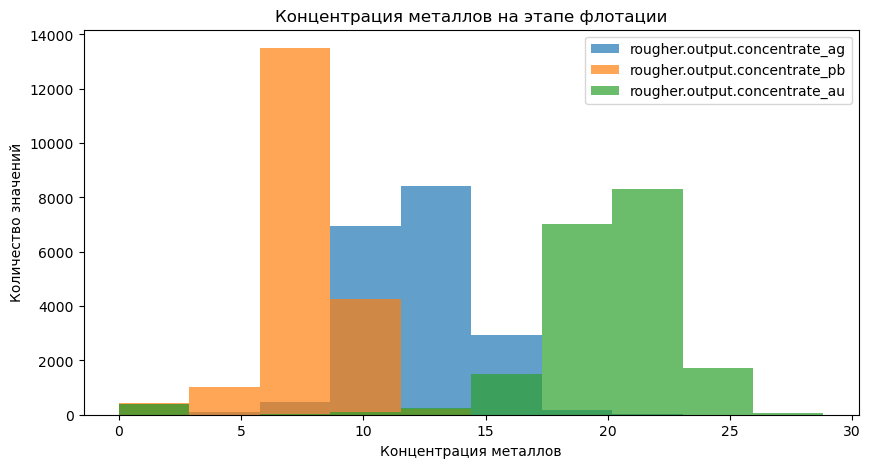

In [342]:
#концентрация металлов Au, Pb, Ag на этапе флотации
rougher_conc = g_r_full[['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au']]
rougher_conc.plot(figsize=(10,5),
                  kind='hist',
                  title='Концентрация металлов на этапе флотации',
                 alpha=0.7)
plt.xlabel('Концентрация металлов')
plt.ylabel('Количество значений')
plt.show()

In [343]:
g_r_full = g_r_full.query('`rougher.output.concentrate_au` >= 1')

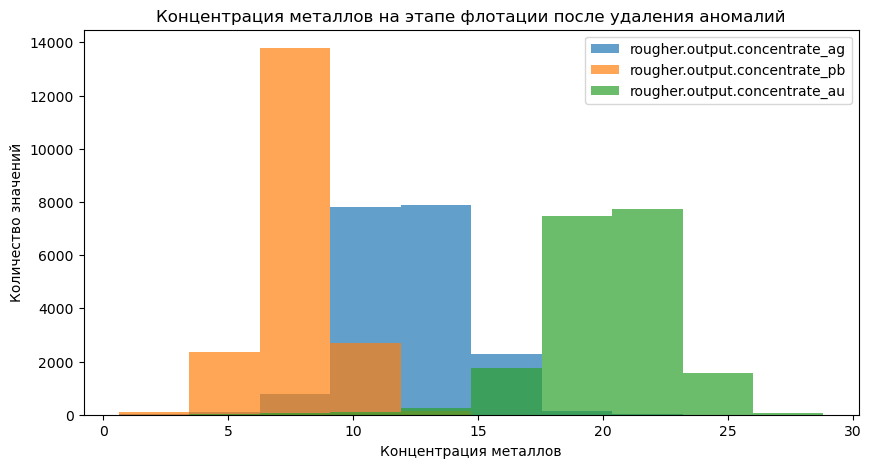

In [344]:
#концентрация металлов Au, Pb, Ag на этапе флотации
rougher_conc = g_r_full[['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au']]
rougher_conc.plot(figsize=(10,5),
                  kind='hist',
                  title='Концентрация металлов на этапе флотации после удаления аномалий',
                 alpha=0.7)
plt.xlabel('Концентрация металлов')
plt.ylabel('Количество значений')
plt.show()

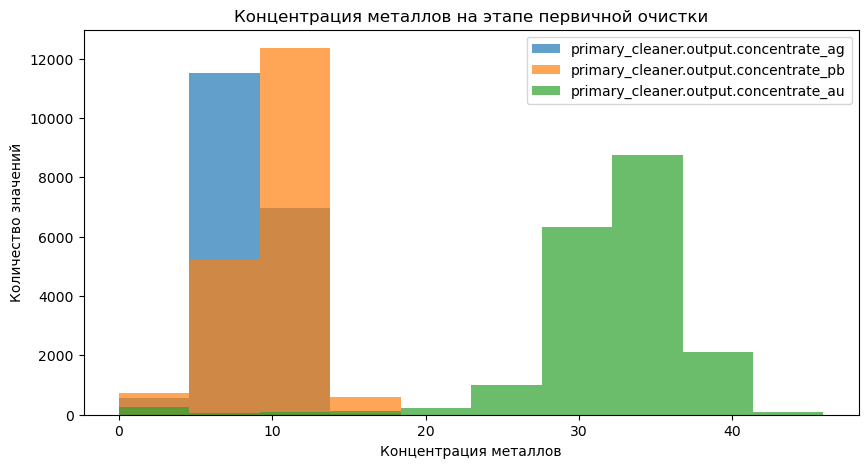

In [345]:
#концентрация металлов Au, Pb, Ag на этапе первичной очистки
primary_cleaner_conc = g_r_full[['primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_au']]
primary_cleaner_conc.plot(figsize=(10,5), 
                          kind='hist', 
                          title='Концентрация металлов на этапе первичной очистки',
                         alpha=0.7)
plt.xlabel('Концентрация металлов')
plt.ylabel('Количество значений')
plt.show()

In [346]:
g_r_full = g_r_full.query('`primary_cleaner.output.concentrate_au` >= 1')

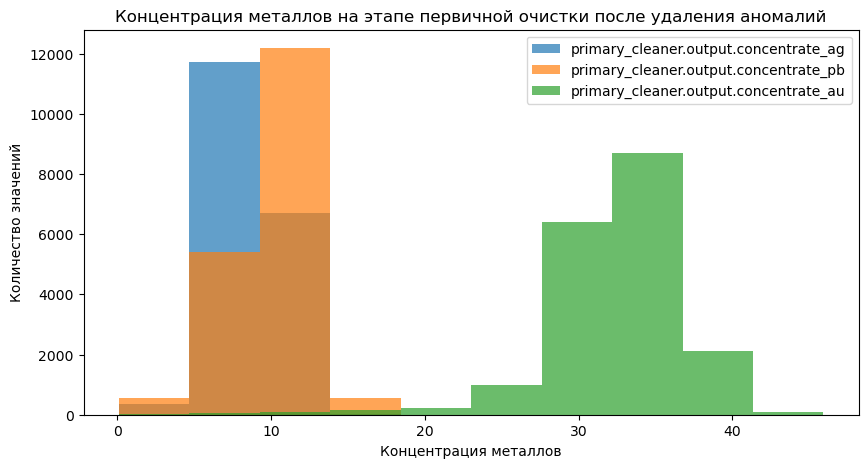

In [347]:
#концентрация металлов Au, Pb, Ag на этапе первичной очистки после удаления аномалий
primary_cleaner_conc = g_r_full[['primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_au']]
primary_cleaner_conc.plot(figsize=(10,5), 
                          kind='hist', 
                          title='Концентрация металлов на этапе первичной очистки после удаления аномалий',
                         alpha=0.7)
plt.xlabel('Концентрация металлов')
plt.ylabel('Количество значений')
plt.show()

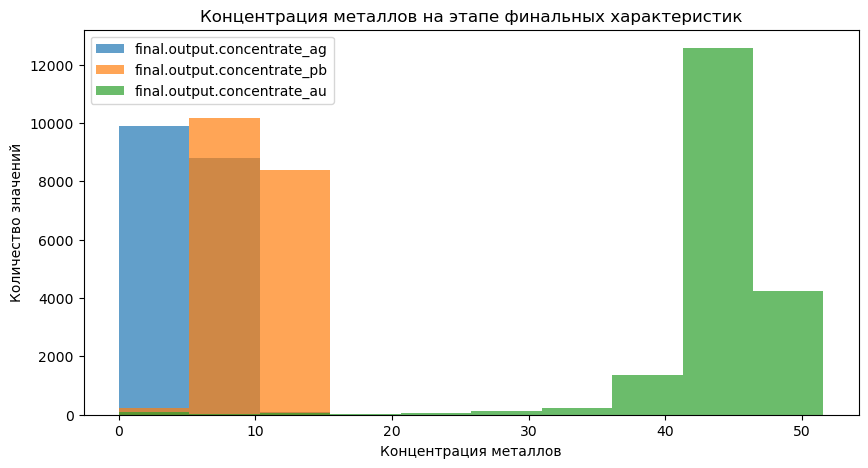

In [348]:
#концентрация металлов Au, Pb, Ag на этапе финальных характеристик
final_conc = g_r_full[['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au']]
final_conc.plot(figsize=(10,5),
               kind='hist',
               title='Концентрация металлов на этапе финальных характеристик',
               alpha=0.7)
plt.xlabel('Концентрация металлов')
plt.ylabel('Количество значений')
plt.show()

In [349]:
g_r_full = g_r_full.query('`final.output.concentrate_au` >= 1')

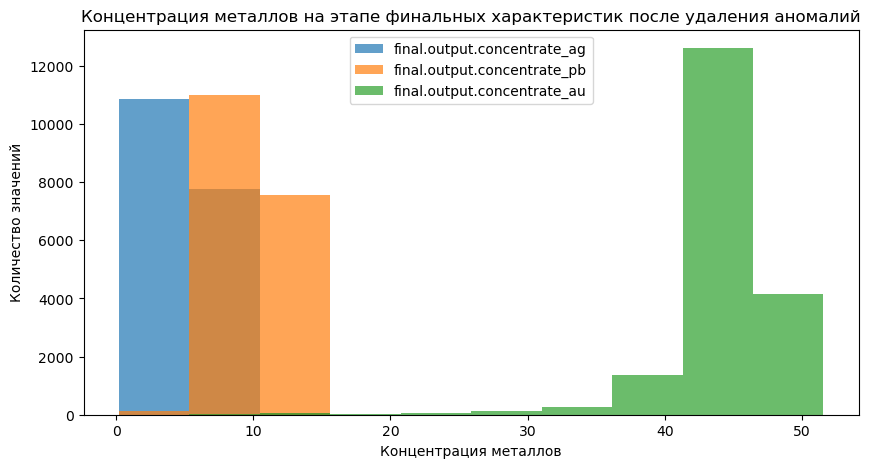

In [350]:
#концентрация металлов Au, Pb, Ag на этапе финальных характеристик
final_conc = g_r_full[['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au']]
final_conc.plot(figsize=(10,5),
               kind='hist',
               title='Концентрация металлов на этапе финальных характеристик после удаления аномалий',
               alpha=0.7)
plt.xlabel('Концентрация металлов')
plt.ylabel('Количество значений')
plt.show()

С каждым последующим этапом, начиная от этапа флотации, концентрации золота значительно возрастает, в то время, как остальные металлы уменьшаются

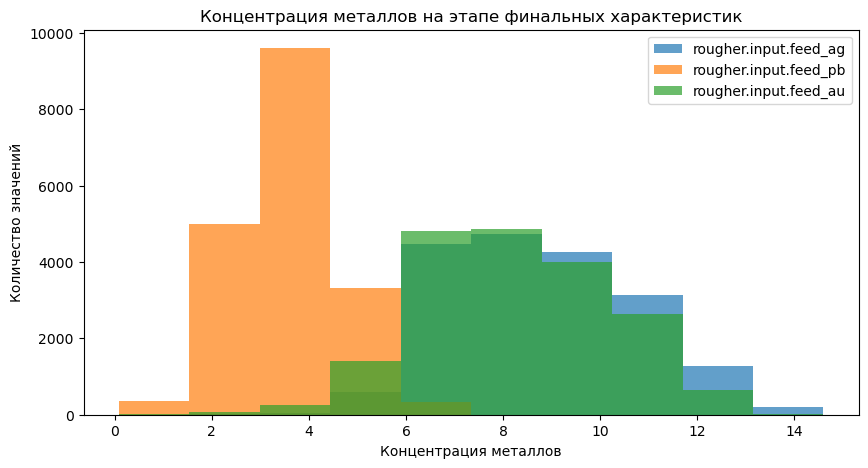

In [351]:
#концентрация металлов Au, Pb, Ag на этапе финальных характеристик
final_conc = g_r_full[['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au']]
final_conc.plot(figsize=(10,5),
               kind='hist',
               title='Концентрация металлов на этапе финальных характеристик',
               alpha=0.7)
plt.xlabel('Концентрация металлов')
plt.ylabel('Количество значений')
plt.show()

In [352]:
g_r_full = g_r_full.query('`rougher.input.feed_au` >= 1')

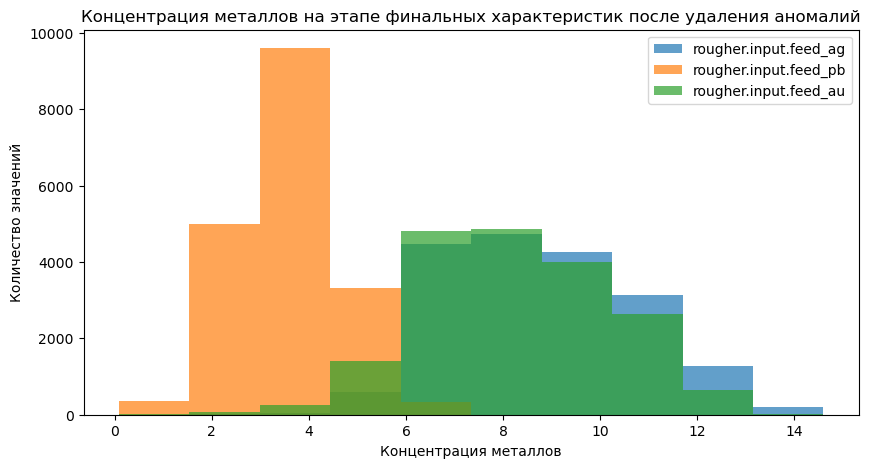

In [353]:
#концентрация металлов Au, Pb, Ag на этапе финальных характеристик
final_conc = g_r_full[['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au']]
final_conc.plot(figsize=(10,5),
               kind='hist',
               title='Концентрация металлов на этапе финальных характеристик после удаления аномалий',
               alpha=0.7)
plt.xlabel('Концентрация металлов')
plt.ylabel('Количество значений')
plt.show()

In [354]:
g_r_train = g_r_train.query('`rougher.output.concentrate_au` >= 1')
g_r_train = g_r_train.query('`primary_cleaner.output.concentrate_au` >= 1')
g_r_train = g_r_train.query('`final.output.concentrate_au` >= 1')
g_r_train = g_r_train.query('`rougher.input.feed_au` >= 1')

In [355]:
g_r_train = g_r_train.query('`rougher.output.concentrate_pb` > 0')
g_r_train = g_r_train.query('`primary_cleaner.output.concentrate_pb` > 0')
g_r_train = g_r_train.query('`final.output.concentrate_pb` > 0')
g_r_train = g_r_train.query('`rougher.input.feed_pb` > 0')

In [356]:
g_r_train = g_r_train.query('`rougher.output.concentrate_ag` > 0')
g_r_train = g_r_train.query('`primary_cleaner.output.concentrate_ag` > 0')
g_r_train = g_r_train.query('`final.output.concentrate_ag` > 0')
g_r_train = g_r_train.query('`rougher.input.feed_ag` > 0')

### Определение размера гранул

In [357]:
g_r_train.columns

Index(['rougher.input.feed_au', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_sol',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_f

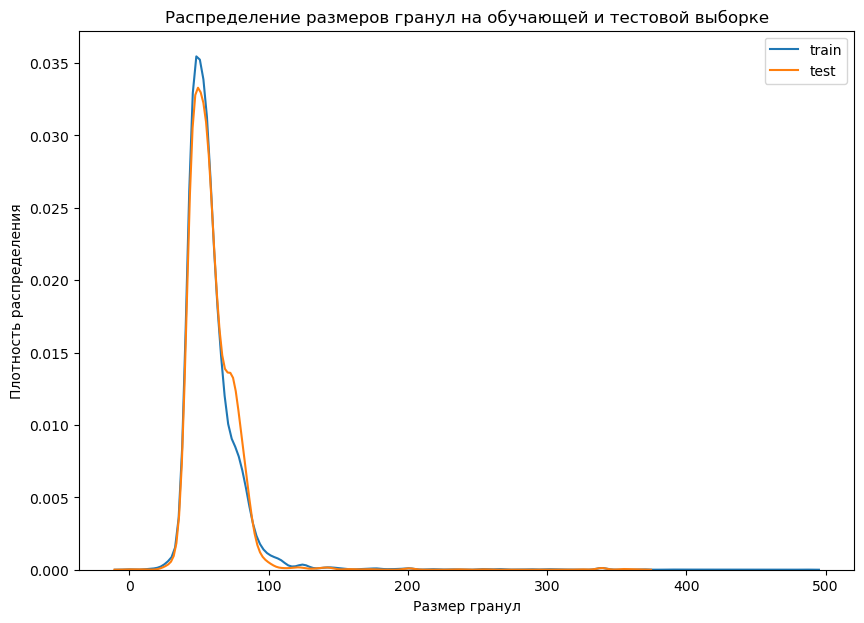

In [358]:
sns.kdeplot(g_r_train['rougher.input.feed_size'])
sns.kdeplot(g_r_test['rougher.input.feed_size'])
plt.title('Распределение размеров гранул на обучающей и тестовой выборке')
plt.legend(['train', 'test'])
plt.xlabel('Размер гранул')
plt.ylabel('Плотность распределения')
plt.show()

Распределения размеров гранул на обучающей и тестовой выборках схожи, поэтому такие данные можно использовать для моделей.

### Суммарная концентрация всех веществ на разных стадиях

In [359]:
g_r_full.columns

Index(['rougher.input.feed_au', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_sol',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_f

In [360]:
#суммарная концентрация сырья
g_r_full['sum_conc_feed'] = g_r_full[['rougher.input.feed_ag',
                                      'rougher.input.feed_pb',
                                      'rougher.input.feed_sol',
                                      'rougher.input.feed_au']].sum(axis=1)
#суммарная концентрация в черновом концентратах
g_r_full['sum_conc_rougher'] = g_r_full[['rougher.output.concentrate_ag',
                                        'rougher.output.concentrate_pb',
                                        'rougher.output.concentrate_sol',
                                        'rougher.output.concentrate_au']].sum(axis=1)
#суммарная концентрация в финальных концентратах
g_r_full['sum_conc_final'] = g_r_full[['final.output.concentrate_ag',
                                      'final.output.concentrate_pb',
                                      'final.output.concentrate_sol',
                                      'final.output.concentrate_au']].sum(axis=1)
g_r_full[['sum_conc_feed', 'sum_conc_rougher', 'sum_conc_final']].head()

,sum_conc_feed,sum_conc_rougher,sum_conc_final
date,,,
2016-01-15 00:00:00,51.680034,66.424950,63.644396
2016-01-15 01:00:00,50.659114,67.012710,63.957723
2016-01-15 02:00:00,50.609929,66.103793,64.311180
2016-01-15 03:00:00,51.061546,65.752751,63.573449
2016-01-15 04:00:00,47.859163,65.908382,64.004667


Сумма концентрации металлов при переходе от сырья к этапу флотации возрастает, а затем на финальном этапе эта сумма немного уменьшается.

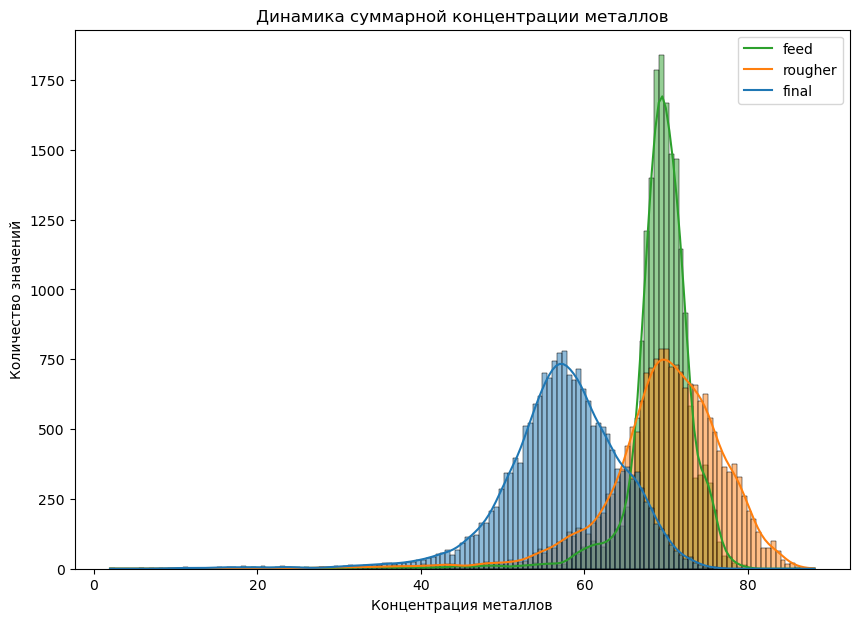

In [361]:
sns.histplot(g_r_full[['sum_conc_feed', 'sum_conc_rougher', 'sum_conc_final']], kde=True)
plt.legend(['feed', 'rougher', 'final'])
plt.title('Динамика суммарной концентрации металлов')
plt.xlabel('Концентрация металлов')
plt.ylabel('Количество значений')
plt.show()

## Создание модели

In [362]:
def smape(target, predicted):
    smape = 1 / len(target) * sum(abs(target - predicted) / ((abs(target) + abs(predicted)) / 2) * 100)
    return smape

In [363]:
def final_smape(target, predicted):
    final_smape = 0.25 * target + 0.75 * predicted
    return final_smape

In [364]:
common_cols = set(g_r_train.columns).intersection(set(g_r_test.columns))

In [365]:
g_r_train = g_r_train[list(common_cols)]

Удалил все столбцы из тренировочной выборки, которых нет в тестовой, так как модель будет обучена некорректно

In [366]:
#разделил тренировочную выборку на признаки, целевой признак rougher и целевой признак final
features_train = g_r_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_rougher = g_r_train['rougher.output.recovery']
target_train_final = g_r_train['final.output.recovery']

In [367]:
#также разделил тестовую выборку на признаки, целевой признак rougher и целевой признак final
features_test = g_r_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_rougher = g_r_test['rougher.output.recovery']
target_test_final = g_r_test['final.output.recovery']

In [368]:
#из признаков сделал одномерный массив, чтобы заработала функция smape
#target_train_rougher = target_train_rougher.ravel()
#target_test_rougher = target_test_rougher.ravel()

In [369]:
scorer = make_scorer(smape, greater_is_better=False)

In [370]:
#state = np.random.RandomState(12345)

### Модель дерева решений

In [371]:
g_r_train.head()

,rougher.state.floatbank10_c_air,rougher.input.feed_au,rougher.output.recovery,rougher.state.floatbank10_f_level,primary_cleaner.input.sulfate,rougher.input.feed_sol,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank2_b_air,rougher.input.feed_pb,rougher.input.floatbank10_sulfate,...,primary_cleaner.state.floatbank8_c_level,rougher.state.floatbank10_e_air,rougher.input.feed_size,rougher.state.floatbank10_b_level,secondary_cleaner.state.floatbank5_b_air,rougher.input.floatbank10_xanthate,secondary_cleaner.state.floatbank3_a_air,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_d_level,primary_cleaner.state.floatbank8_b_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,1602.375000,6.486150,87.107763,-451.939636,127.092003,36.808594,-499.340973,23.893660,2.284912,11.986616,...,-498.666595,1404.472046,55.486599,-434.715027,8.079666,6.007990,23.961798,1549.873901,-493.428131,-516.403442
2016-01-15 01:00:00,1600.479580,6.478583,86.843261,-450.119001,125.629232,35.753385,-499.446897,23.889530,2.266033,11.971193,...,-499.315107,1399.227084,57.278666,-449.953435,7.984757,6.005766,23.970550,1575.994189,-498.931665,-499.865889
2016-01-15 02:00:00,1599.672797,6.362222,86.842308,-450.527147,123.819808,35.971630,-499.901982,23.886657,2.159622,11.920603,...,-500.870069,1399.180945,57.510649,-450.008530,8.013877,6.197377,23.913535,1602.003542,-499.827444,-500.607762
2016-01-15 03:00:00,1600.012842,6.118189,87.226430,-449.790835,122.270188,36.862241,-499.944710,23.955516,2.037807,11.630094,...,-500.727997,1400.943157,57.792734,-450.619948,7.977324,6.203177,23.966838,1600.304144,-500.052575,-499.677094
2016-01-15 04:00:00,1600.357732,5.663707,86.688794,-450.407128,117.988169,34.347666,-499.990309,23.955345,1.786875,10.957755,...,-500.888152,1401.560902,56.047189,-449.599614,7.894242,6.198826,23.985703,1599.581894,-500.593010,-500.323246


In [377]:
#сделал одинаковый порядок для признаков в трейне и тесте
features_test = features_test[features_train.columns]

In [375]:
for train_col, test_col in zip(features_train.columns, features_test.columns):
    print(train_col, '*'*10, test_col, '*'*10, test_col==train_col)

rougher.state.floatbank10_c_air ********** rougher.state.floatbank10_c_air ********** True
rougher.input.feed_au ********** rougher.input.feed_au ********** True
rougher.state.floatbank10_f_level ********** rougher.state.floatbank10_f_level ********** True
primary_cleaner.input.sulfate ********** primary_cleaner.input.sulfate ********** True
rougher.input.feed_sol ********** rougher.input.feed_sol ********** True
secondary_cleaner.state.floatbank3_b_level ********** secondary_cleaner.state.floatbank3_b_level ********** True
secondary_cleaner.state.floatbank2_b_air ********** secondary_cleaner.state.floatbank2_b_air ********** True
rougher.input.feed_pb ********** rougher.input.feed_pb ********** True
rougher.input.floatbank10_sulfate ********** rougher.input.floatbank10_sulfate ********** True
secondary_cleaner.state.floatbank6_a_air ********** secondary_cleaner.state.floatbank6_a_air ********** True
primary_cleaner.state.floatbank8_a_air ********** primary_cleaner.state.floatbank8_a_a

### DecisionTreeRegressor

In [424]:
#подбор гиперпараметров для дерева решений с помощью GridSearchCV
parameters = {'max_depth': [1, 5, 10], 'min_samples_leaf': [1, 5, 10]}
model_dtr = DecisionTreeRegressor(random_state=12345)
model_dtr = GridSearchCV(model, parameters, cv=5, scoring=scorer, n_jobs=-1)
model_dtr.fit(features_train, target_train_rougher)
cv_score_rougher = model_dtr.best_score_
cv_score_rougher = cv_score_rougher * -1

In [425]:
parameters = {'max_depth': [1, 5, 10], 'min_samples_leaf': [1, 5, 10]}
model_dtr = DecisionTreeRegressor(random_state=12345)
model_dtr = GridSearchCV(model, parameters, cv=5, scoring=scorer, n_jobs=-1)
model_dtr.fit(features_train, target_train_final)
cv_score_final = model_dtr.best_score_
cv_score_final = cv_score_final * -1

In [426]:
print(f'Модель дерева решений показала результат метрики final_smape равный {round(final_smape(cv_score_rougher, cv_score_final), 2)}')

Модель дерева решений показала результат метрики final_smape равный 8.55


### Модель линейной регрессии

In [403]:
parameters = {}
model_lr = LinearRegression()
model_lr = GridSearchCV(model_lr, parameters, cv=5, scoring=scorer, n_jobs=-1)
model_lr.fit(features_train, target_train_rougher)
cv_score_rougher = model_lr.best_score_
cv_score_rougher = cv_score_rougher * -1
cv_score_rougher

7.09766106410414

In [404]:
parameters = {}
model_lr = LinearRegression()
model_lr = GridSearchCV(model_lr, parameters, cv=5, scoring=scorer, n_jobs=-1)
model_lr.fit(features_train, target_train_final)
cv_score_final = model_lr.best_score_
cv_score_final = cv_score_final * -1
cv_score_final

9.356372636323917

In [405]:
print(f'Модель линейной регрессии показала результат метрики final_smape равный {round(final_smape(cv_score_rougher, cv_score_final), 2)}')

Модель линейной регрессии показала результат метрики final_smape равный 8.79


### Модель случайного леса

In [429]:
#подбор гиперпараметров для случайного леса с помощью GridSearchCV
parameters = {'n_estimators' : [1, 10, 20, 50], 'max_depth' : [1, 5, 10]}
model_rfr = RandomForestRegressor(random_state=12345)
model_rfr = GridSearchCV(model_rfr, parameters, cv=5, scoring=scorer, n_jobs=-1, verbose=10)
model_rfr.fit(features_train, target_train_rougher)
cv_score_rougher = model_rfr.best_score_
cv_score_rougher = cv_score_rougher * -1
best_params_rgr_rougher = model_rfr.best_params_
print(f'Лучшие параметры: {best_params_rgr_rougher}')
cv_score_rougher

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие параметры: {'max_depth': 5, 'n_estimators': 20}


6.316343322191673

In [430]:
#подбор гиперпараметров для случайного леса с помощью GridSearchCV
parameters = {'n_estimators' : [1, 10, 20, 50], 'max_depth' : [1, 5, 10]}
model_rfr = RandomForestRegressor(random_state=12345)
model_rfr = GridSearchCV(model_rfr, parameters, cv=5, scoring=scorer, n_jobs=-1, verbose=10)
model_rfr.fit(features_train, target_train_final)
cv_score_final = model_rfr.best_score_
cv_score_final = cv_score_final * -1
best_params_rgr_final = model_rfr.best_params_
print(f'Лучшие параметры: {best_params_rgr_final}')
cv_score_final

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие параметры: {'max_depth': 1, 'n_estimators': 10}


8.910388823940414

In [431]:
print(f'Модель случайного леса показала результат метрики final_smape равный {round(final_smape(cv_score_rougher, cv_score_final), 2)}')

Модель случайного леса показала результат метрики final_smape равный 8.26


### ElasticNet

In [412]:
parameters = {'alpha' : [0.1, 0.5, 1], 'max_iter' : [100, 200, 300]}
model_en = ElasticNet(random_state=12345)
model_en = GridSearchCV(model_en, parameters, cv=5, scoring=scorer, n_jobs=-1)
model_en.fit(features_train, target_train_rougher)
cv_score_rougher = model_en.best_score_
cv_score_rougher = cv_score_rougher * -1
cv_score_rougher

C:\Users\trombee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.217e+03, tolerance: 8.111e+01
  model = cd_fast.enet_coordinate_descent(


6.709891552242269

In [413]:
parameters = {'alpha' : [0.1, 0.5, 1], 'max_iter' : [100, 200, 300]}
model_en = ElasticNet(random_state=12345)
model_en = GridSearchCV(model_en, parameters, cv=5, scoring=scorer, n_jobs=-1)
model_en.fit(features_train, target_train_final)
cv_score_final = model_en.best_score_
cv_score_final = cv_score_final * -1
cv_score_final

C:\Users\trombee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.405e+05, tolerance: 1.027e+02
  model = cd_fast.enet_coordinate_descent(


9.115261186488107

In [414]:
print(f'Модель ElasticNet показала результат метрики final_smape равный {round(final_smape(cv_score_rougher, cv_score_final), 2)}')

Модель ElasticNet показала результат метрики final_smape равный 8.51


### Lasso

In [415]:
parameters = {'alpha' : [0.1, 0.5, 1], 'max_iter' : [100, 200, 300]}
model_lasso = Lasso(random_state=12345)
model_lasso = GridSearchCV(model_lasso, parameters, cv=5, scoring=scorer, n_jobs=-1)
model_lasso.fit(features_train, target_train_rougher)
cv_score_rougher = model_lasso.best_score_
cv_score_rougher = cv_score_rougher * -1
cv_score_rougher

C:\Users\trombee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.670e+04, tolerance: 8.111e+01
  model = cd_fast.enet_coordinate_descent(


6.860481386151298

In [416]:
parameters = {'alpha' : [0.1, 0.5, 1], 'max_iter' : [100, 200, 300]}
model_lasso = Lasso(random_state=12345)
model_lasso = GridSearchCV(model_lasso, parameters, cv=5, scoring=scorer, n_jobs=-1)
model_lasso.fit(features_train, target_train_final)
cv_score_final = model_lasso.best_score_
cv_score_final = cv_score_final * -1
cv_score_final

C:\Users\trombee\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.659e+05, tolerance: 1.027e+02
  model = cd_fast.enet_coordinate_descent(


9.078866911605088

In [417]:
print(f'Модель Lasso показала результат метрики final_smape равный {round(final_smape(cv_score_rougher, cv_score_final), 2)}')

Модель Lasso показала результат метрики final_smape равный 8.52


## Проверка лучшей модели на тестовой выборке и сравнение с константной моделью

### Константная модель DummyRegressor

In [438]:
model_dummy = DummyRegressor()
model_dummy.fit(features_train, target_train_rougher)
dummy_predict = model_dummy.predict(features_test)
dummy_smape_rougher = smape(target_test_rougher, dummy_predict)

print(f'rougher sMAPE для константной модели = {dummy_smape_rougher}')

rougher sMAPE для константной модели = 6.093128475294952


In [439]:
model_dummy = DummyRegressor()
model_dummy.fit(features_train, target_train_final)
dummy_predict = model_dummy.predict(features_test)
dummy_smape_final = smape(target_test_final, dummy_predict)

print(f'final sMAPE для константной модели = {dummy_smape_final}')

final sMAPE для константной модели = 9.170346362291186


In [440]:
print(f'final_smape для константной модели равен {final_smape(dummy_smape_rougher, dummy_smape_final)}')

final_smape для константной модели равен 8.401041890542128


### Проверка RFR на тесте

In [441]:
model_rfr = RandomForestRegressor(random_state=12345, max_depth=5, n_estimators=20)
model_rfr.fit(features_train, target_train_rougher)
rfr_predict_rougher = model_rfr.predict(features_test)
rfr_rougher_smape = smape(target_test_rougher, rfr_predict_rougher)
rfr_rougher_smape

3.858380152771629

In [442]:
model_rfr = RandomForestRegressor(random_state=12345, max_depth=1, n_estimators=10)
model_rfr.fit(features_train, target_train_final)
rfr_predict_final = model_rfr.predict(features_test)
rfr_final_smape = smape(target_test_final, rfr_predict_final)
rfr_final_smape

8.543784676054361

In [443]:
final_smape(rfr_rougher_smape, rfr_final_smape)

7.372433545233679

## Итоговый вывод

<div style="border:solid orange 2px; padding: 20px"> 
    
В ходе выполнения работы были проделаны следующие шаги:
- Проведены подготовка данных:
    - Загружены данные;
    - Проведена проверка на корректность расчетов об эффективности обогащения. В итоге проверки расчеты корректные, метрика MAE показала результат сильно ниже нуля;
    - Были проанализированы признаки, недоступные в тестовой выборке. Это произошло из-за офлайн и онлайн метрики. Т.е. в обучающей выборке собраны исторические данные, соответственно там имеются и данных на выходе (output). А в тестовой выборке данные реального времени, которые подаются на вход модели;
    - Проведена предобработка данных: заполнены пропуски, удалены аномальные значения, проанализирован распределение признаков на обучающей и тестовой выборках
- Проанализированы данные:
    - Проанализирована динамика изменения концентрации каждого металла. С каждым последующим этапом концентрация золота возрастает, а других металлов уменьшается;
    - Сравнены распределения размеров гранул на обучающей и тестовой выборке. Распределения оказались схожи, поэтому данные можно использовать для обучения моделей;
    - Также было выяснено, что суммарная концентрация металлов уменьшается ближе к финальной стадии.
- Построение и выбор лучшей модели:
    - Модель линейной регрессии показала результат final_smape равный 8.79
    - Модель дерева решений показала результат final_smape равный 8.55
    - Модель случайного леса показала результа final_smape равный 8.26
    - Модель Lasso показала результа final_smape равный 8.52
    - Модель ElasticNet показала результа final_smape равный 8.51
    - final_smape константной модели равен 8.4
    
По итогу, лучшей моделью на обучающем наборе данных стала модель случайного леса, с результатом в 8.26.

Далее эта модель была проверена на тестовой выборке, где показала результат равный 7.37. Данная модель нам подходит, так как значительно превосходит результаты константной модели в 8.4.